In [20]:
from __future__ import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader
 # must have this function locally or in path
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
%pylab inline
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")
import scipy.stats
import os
#set this to true while deeloping to subsample data
DEVELOPING = False

#chose day hours vs night hours:
DAYTIME = (6, 18)


Populating the interactive namespace from numpy and matplotlib


In [21]:
alpha = 0.05

In [22]:
datestring01 = '201501'
datestring06 = '201506'
b201501 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring01 + '-citibike-tripdata.csv')
b201501.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [23]:
b201506 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring06 + '-citibike-tripdata.csv')
b201506.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


In [24]:
if DEVELOPING:
    b2015 = b201501[::1000]
else:
    b2015 = pd.concat([b201501, b201506])

In [25]:
b2015['date'] = pd.to_datetime(b2015.starttime)

In [10]:
b2015.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,starthour
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00,0
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,0
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,0
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,0
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00,0


In [27]:
b2015['starthour'] = pd.to_numeric(b2015.starttime.apply(lambda x: 
                                                           x.split()[1].split(':')[0]))

In [28]:
b2015.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,starthour
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00,0
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,0
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,0
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,0
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00,0


In [29]:
b2015['riderday'] = (b2015.starthour.values > DAYTIME[0]) & (b2015.starthour.values < DAYTIME[1])

In [30]:
b2015.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,starthour,riderday
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00,0,False
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,0,False
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,0,False
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,0,False
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00,0,False


In [31]:
latlon = (b2015[['start station latitude', 
                'start station longitude']].values.astype(float))
print(len(latlon))
b2015 = b2015.drop(b2015.columns[5:-1], axis=1).drop(b2015.columns[1:3], axis=1)
b2015.head()

1226771


,tripduration,start station id,start station name,riderday
0,1346,455,1 Ave & E 44 St,False
1,363,434,9 Ave & W 18 St,False
2,346,491,E 24 St & Park Ave S,False
3,182,384,Fulton St & Waverly Ave,False
4,969,474,5 Ave & E 29 St,False


In [33]:
b2015.describe()

,tripduration,start station id
count,1.226771e+06,1.226771e+06
mean,8.463465e+02,4.561577e+02
std,3.052017e+03,3.730900e+02
min,6.000000e+01,7.200000e+01
25%,3.810000e+02,3.070000e+02
50%,6.050000e+02,4.170000e+02
75%,9.920000e+02,4.920000e+02
max,1.691873e+06,3.002000e+03


In [34]:
print(b2015.riderday.sum())

819517


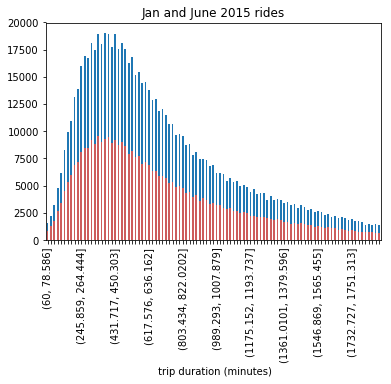

In [41]:
# plot daytime trip duration histogram in 100 bins
# plot 0% to 95% percentile because I expect these distribution to be long tailed and I see 43,000 hour trips above
pc = np.percentile(b2015.tripduration, [0, 95])
bins = np.linspace(int(pc[0]), int(pc[1] / 100) * 100, 100)
dayax = b2015[b2015.riderday].tripduration.groupby(
    pd.cut(b2015[b2015.riderday].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False)
dayax.set_title("Jan and June 2015 rides")
# plot nighttime trip duration histogram
b2015[~b2015.riderday].tripduration.groupby(
    pd.cut(b2015[~b2015.riderday].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False, ax=dayax, 
                                             color='IndianRed')
xlab = dayax.get_xticklabels()
dayax.set_xticklabels(['' if float(i)%10 > 0 else xlab[i] for i in range(len(xlab))]);
dayax.set_xlabel(" trip duration (minutes)");


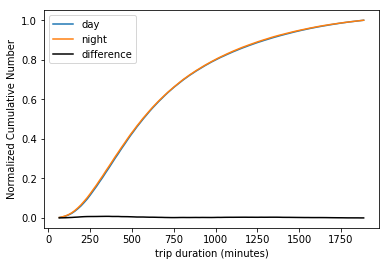

In [42]:
#print df.ageS, df.ageS.cumsum()

csD = b2015[b2015.riderday].tripduration.groupby(pd.cut(b2015[b2015.riderday].tripduration, 
                                                 bins)).agg([count_nonzero]).cumsum()

csN = b2015[~b2015.riderday].tripduration.groupby(pd.cut(b2015[~b2015.riderday].tripduration, 
                                                  bins)).agg([count_nonzero]).cumsum()

#print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "day")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "night")
pl.plot(bins[:-1] + 5, np.abs(csN / csN.max() - csD / csD.max()), 'k-',
        label = "difference")
pl.xlabel("trip duration (minutes)")
pl.ylabel("Normalized Cumulative Number")
pl.legend();

In [45]:
ks = scipy.stats.ks_2samp(b2015[b2015.riderday].tripduration, b2015[~b2015.riderday].tripduration)
print (ks)
if ks[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated " + 
            "by the same parent distribution is rejected (p<0.05)")
    

Ks_2sampResult(statistic=0.011038871053695483, pvalue=3.1069424761840428e-29)
The Null hypothesis that the two samples are generated by the same parent distribution is rejected (p<0.05)


In [49]:
dfday = b2015[b2015.riderday].iloc[np.random.choice(range(len(b2015[b2015.riderday])), (~b2015.riderday).sum(), 
                                      replace=False)]

In [50]:
parsons = scipy.stats.pearsonr(np.sort(dfday.tripduration), np.sort(b2015[~b2015.riderday].tripduration))
print ("Parson's test result", parsons)
if parsons[1] >= alpha: 
    print (r"The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%parsons[1])
 

Parson's test result (0.8870732270683096, 0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)


In [52]:
spearmanr = scipy.stats.spearmanr(np.sort(dfday.tripduration), np.sort(b2015[~b2015.riderday].tripduration))
print ("Spearman's r test result", spearmanr)
if spearmanr[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%spearmanr[1])
 

Spearman's r test result SpearmanrResult(correlation=0.99999932069264474, pvalue=0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions. is rejected (p = 0.000<0.05)
